In [389]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

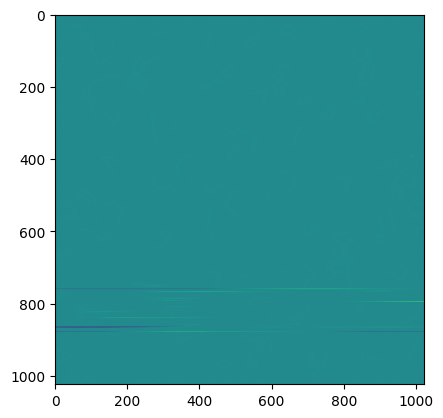

In [468]:
# initial_flattened = np.load('initial_flattened.npy')
# initial_flattened = np.load('./scars_initial_flattened/initial_flattened_20220208_7ng_piano_3mMNiCl2.0_00004 (1).spm.npy')
# initial_flattened = np.load('./scars_initial_flattened/initial_flattened_20220811_nickedcatenane_6ng_nicl2_mgcl2.0_00029.spm.npy')
# initial_flattened = np.load('./scars_initial_flattened/initial_flattened_20221017_BW_mica_disc_test_minicircles339.0_00007.spm.npy')
# initial_flattened = np.load('./scars_initial_flattened/initial_flattened_20221028_HU_1.ng_DDNA_7.5ng_PLL.0_00006.spm.npy')
# initial_flattened = np.load('./scars_initial_flattened/initial_flattened_20221028_HU_5ng_DDNA_10ng_PLL.0_00015.spm.npy')
initial_flattened = np.load('./scars_initial_flattened/initial_flattened_20221028_HU_5ng_DDNA_10ng_PLL.0_00024.spm.npy')
plt.imshow(initial_flattened)
plt.show()

Surface level dive:

Iterate through y, stopping at length - max_scar_width
    Iterate through x
        Get position in the 1D data?
            get the row that we’re working on?
            iterate from 1 to the max scar width
                top = MIN(the pixel we are looking at, or the nth pixel below it)
                bottom = MAX()

                top fluctuates between highest pixel and the lowest one as k increases, depending on if the new pixel is lower.
                bottom fluctuates between old bottom and second to lowest pixel depending on which is higher
                bottom will monotonically shift downwards
                top will fluctuate between being highest and lowest in the stack
                TLDR finding sharp changes in height - possible bug? 

            if k <= maximum scar width
                find the current position in the scars array
                iterate through k, decrementing each time

// Kill too short segments, clamping result along the way
iterate through y 
    get mask array position

    iterate through x and increment k (K is length of the scar)

        IF POINT IS HIGH UP ENOUGH, SET TO 1 and increment scar length
        if mask value at x,y > threshold_high:
            mrow[j] = 1.0
            k++
            continue
        IF POINT IS NOT HIGH UP ENOUGH (reached the end) and the scar is short, delete the scar
        if k && k < min_scar_length:
            delete the skar (horizontal positions)
            while(k):
                mrow[j-k] - 0.0
                k--




In [469]:
def median_flattening(image: np.ndarray, mask: np.ndarray = None):
    if mask is not None:
        read_matrix = np.ma.masked_array(image, mask=mask, fill_value=np.nan).filled()
    else:
        read_matrix = image

    for j in range(image.shape[0]):
        # Get the median of the row
        m = np.nanmedian(read_matrix[j, :])
        # print(m)
        if not np.isnan(m):
            image[j, :] -= m
    return image

def median_differences_flattening(image: np.ndarray, mask: np.ndarray = None):
    if mask is not None:
        read_matrix = np.ma.masked_array(image, mask=mask, fill_value=np.nan).filled()
    else:
        read_matrix = image

    for j in range(read_matrix.shape[0]):
        if j > 0:
            median_height_diff_above = np.nanmedian(read_matrix[j, :] - read_matrix[j-1, :])
            # print(f'median difference in height: {median_height_diff_above}')
            image[j, :] -= median_height_diff_above
    return image

def remove_plane_tilt(image: np.ndarray, mask: np.ndarray = None):
    if mask is not None:
        read_matrix = np.ma.masked_array(image, mask=mask, fill_value=np.nan).filled()
    else:
        read_matrix = image

    # LOBF
    # Calculate medians
    medians_x = [np.nanmedian(read_matrix[:, i]) for i in range(read_matrix.shape[1])]
    medians_y = [np.nanmedian(read_matrix[j, :]) for j in range(read_matrix.shape[0])]

    # Fit linear x
    px = np.polyfit(range(0,len(medians_x)), medians_x, 1)
    print(f'px: {px}')
    py = np.polyfit(range(0,len(medians_y)), medians_y, 1)
    print(f'py: {py}')

    print(f'px[0]: {px[0]}')
    print(f'np.isnan(px[0]): {np.isnan(px[0])}')

    if px[0] != 0 and not np.isnan(px[0]):
        print('removing x plane tilt')
        for j in range(0, image.shape[0]):
            for i in range(0, image.shape[1]):
                image[j, i] -= px[0] * (i)

    if py[0] != 0 and not np.isnan(py[0]):
        print('removing y plane tilt')
        for j in range(0, image.shape[0]):
            for i in range(0, image.shape[1]):
                image[j, i] -= py[0] * (j)
    
    return image

def remove_quadratic(image: np.ndarray, mask: np.ndarray = None):
    if mask is not None:
        read_matrix = np.ma.masked_array(image, mask=mask, fill_value=np.nan).filled()
    else:
        read_matrix = image

    # Calculate medians
    medians_x = [np.nanmedian(read_matrix[:, i]) for i in range(read_matrix.shape[1])]

    # Fit quadratic x
    px = np.polyfit(range(0,len(medians_x)), medians_x, 2)

    # Handle divide by zero
    if px[0] != 0 and not np.isnan(px[0]):
        # Remove quadratic x 
        cx = -px[1]/(2*px[0])
        for j in range(0, image.shape[0]):
            for i in range(0, image.shape[1]):
                image[j, i] -= px[0] * (i-cx)**2
    return image

def add_circles(image: np.ndarray, height: int = 10, number: int = 10, min_size: int = 20, max_size: int = 50, min_thickness: int = 2, max_thickness: int = 10):
    sx = image.shape[1]
    sy = image.shape[0]

    for i in range(number):
        size = np.random.randint(min_size, max_size)
        thickness = np.random.randint(min_thickness, max_thickness)
        image = add_ring(image, outer_size=size + thickness, inner_size=size, centre=(np.random.randint(0,sx), np.random.randint(0, sy)), height=height)

    return image

def add_ring(image: np.ndarray, outer_size: int = 200, inner_size: int = 100, centre: tuple = (0, 0), height: int = 10):
    cx = centre[0]
    cy = centre[1]
    for i in range(-outer_size, outer_size):
        for j in range(-outer_size, outer_size):
                if j+cy < image.shape[0] - 1:
                    if i+cx < image.shape[1] - 1:
                        if ((i)**2 + (j)**2) < outer_size**2 and i**2 + j**2 > inner_size**2:             
                            image[i+cx, j+cy] += height
    return image

def add_scan_lines(image: np.ndarray, magnitude: int = 10):
    for j in range(image.shape[0]):
        image[j, :] += (np.random.random() - 0.5) * magnitude
    return image

def add_random_noise(image: np.ndarray, magnitude: int = 1):
    for j in range(image.shape[0]):
        for i in range(image.shape[1]):
            image[j, i] += (np.random.random() - 0.5) * magnitude
    return image

def add_slant(image: np.ndarray, magnitude_x: float = 0.01, magnitude_y: float = 0.03):
    for j in range(image.shape[0]):
        for i in range(image.shape[1]):
            image[j, i] += (magnitude_y*j) + (magnitude_x*i)
    return image

def add_quadratic(image: np.ndarray, a: float = 0, b: float = 0):
    cx = int(image.shape[1]/2)
    cy = int(image.shape[0]/2)
    for j in range(image.shape[0]):
        for i in range(image.shape[1]):
            image[j, i] += a*(i-cx)**2 + b*(i-cx) 
    return image

def add_scars(image: np.ndarray, number: int = 10, level: float = 15, min_size: int = None, max_size: int = None):
    sx = image.shape[1]
    sy = image.shape[0]
    if min_size is None:
        min_size = sx / 10
    if max_size is None: 
        max_size = sx / 6 
    for i in range(number):
        left = np.random.randint(0, sx-2)
        right = min(sx-1, left + np.random.randint(min_size, max_size))
        image[np.random.randint(0, sy), left:right] = level
    return image

def plot_histogram(image: np.ndarray, title: str = ''):
    plt.figure(figsize=(4, 4), dpi=80)
    plt.hist(image.flatten(), bins=len(np.unique(image)))
    plt.title(title)
    plt.show()
    
def mask_image(image: np.ndarray, std_dev_multiplier: float = 1.0):
    # Calculate threshold value
    mean = np.mean(image)
    std_dev = np.std(image)
    print(f'mean: {mean} std_dev: {std_dev}')
    threshold = mean + std_dev_multiplier * std_dev
    print(f'threshold: {threshold}')

    mask = image > threshold
    # masked_image = np.ma.masked_array(original_image, mask=mask, fill_value=np.nan).filled()

    return mask

def plot_medians(image: np.ndarray, axis: str = 'x'):
    # # Calculate medians
    if axis == 'x':
        medians = [np.nanmedian(image[:, i]) for i in range(image.shape[1])]
    elif axis == 'y':
        medians_y = [np.median(image[j, :]) for j in range(image.shape[0])]

    # Fit quadratic x
    px = np.polyfit(range(0,len(medians)), medians, 2)
    # print(px)

    # Plot quadratic fit
    plt.plot(medians, '.', label='x medians')
    # plt.plot(medians_y, '.', label='y medians')
    plt.legend()
    xs = np.array(range(0, len(medians)))
    fitx = np.array(xs**2 * px[0] + xs * px[1] + px[2])
    plt.plot(range(0, len(medians)), fitx)
    plt.show()



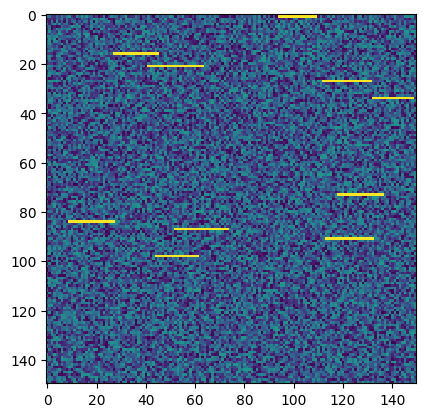

In [470]:
img1 = np.ones((150, 150))
add_random_noise(img1, magnitude=3)
add_scars(img1, number=10, level=5)
plt.imshow(img1, interpolation="None")
plt.show()

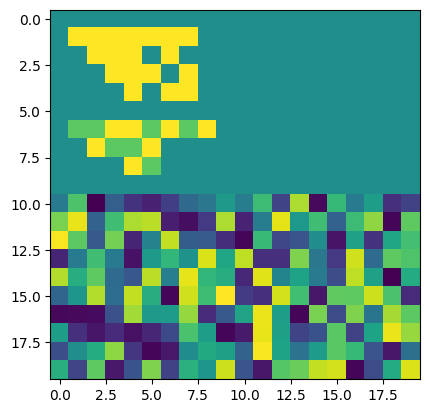

In [471]:
h = 2.0
l = 1.5
np.random.seed(1)
testimg = np.ones((20, 20))
# testimg *= -1
marked = np.zeros((20, 20))
testimg[1,1] = h
testimg[1:3,2] = h
testimg[1:4,3] = h
testimg[1:5,4] = h
testimg[1,5] = h
testimg[3,5] = h
testimg[1,6] = h
testimg[2,6] = h
testimg[4,6] = h
testimg[1,7] = h
testimg[3:5,7] = h

testimg[6,1] = l
testimg[6,2] = l
testimg[7,2] = h
testimg[6,3] = h
testimg[7,3] = l
testimg[6,4] = h
testimg[7,4] = l
testimg[8,4] = h
testimg[6,5] = l
testimg[7,5] = h
testimg[8,5] = l
testimg[6,6] = h
testimg[6,7] = l
testimg[6,8] = h
testimg[10:20,:] = np.random.random((10, 20)) * 2

plt.imshow(testimg)

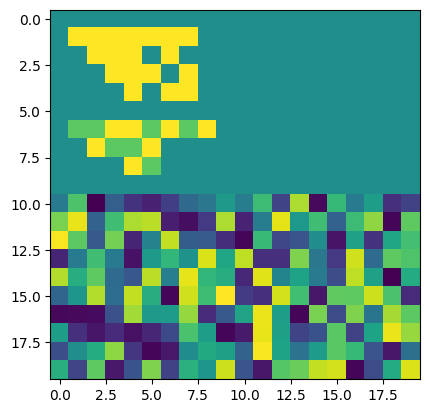

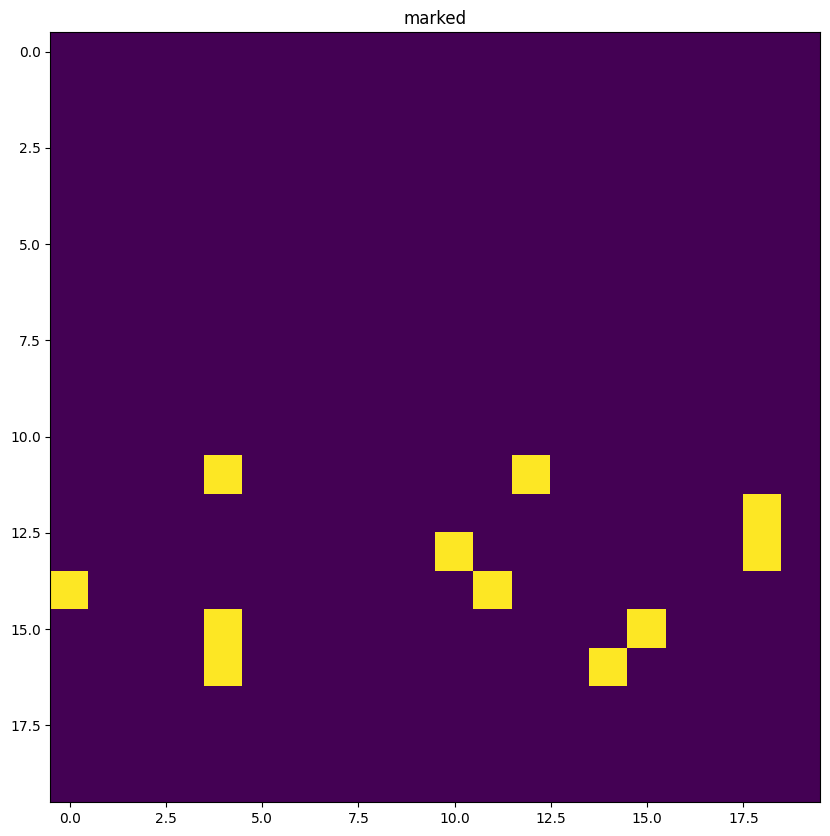

In [472]:
img = testimg
# img = testimg2
# img = initial_flattened

plt.imshow(img)
plt.show()

marked = np.zeros((img.shape[0], img.shape[1]))

LOGGING = False

def log(text):
    if LOGGING:
        print(text)

max_scar_width = 2
rms = np.std(img)
# rms = 0.29440155845492705
log(f'rms: {rms}')
threshold_low = 2

for row in range(img.shape[0]-(max_scar_width + 1)):
    for col in range(img.shape[1]):
        # fig, ax = plt.subplots()
        # ax.imshow(img)
        log(f'row: {row} col: {col} value: {img[row, col]}')
        # rect = patches.Rectangle((col-0.5, row-0.5), 1, 1, linewidth=0.5, edgecolor='w', facecolor='None')
        # ax.add_patch(rect)
        bottom = img[row, col]
        top = img[row+1, col]
        top_positions = (row+1, col)
        k = 1
        while k <= max_scar_width:
            # rect = patches.Rectangle((col-0.5, row-0.5+k), 1, 1, linewidth=1, edgecolor='purple', facecolor='None')
            # ax.add_patch(rect)
            bottom = max(img[row, col], img[row+(k+1), col])
            if img[row+k, col] < top:
                top_positions = (row+k, col)
            top = min(top, img[row+k, col])
            log(f'k: {k} top: {top} bottom: {bottom}')
            log(f'top: {top} bottom: {bottom} diff: {top - bottom} threshold*rms: {threshold_low*rms}')
            log(f'  top: min between ({top_positions[0]}, {top_positions[1]}) and ({row+k}, {col})')
            log(f'  bot: max between ({row}, {col}) and ({row+(k+1)}, {col})')
            if top - bottom >= threshold_low*rms:
                log('breaking')
                break
            k += 1
        log(f'k: {k}')
        if k <= max_scar_width:
            while(k):
                # marked[row + k, col] = (img[k, col] - bottom)/rms
                marked[row+k, col] = 1.0
                # rect = patches.Rectangle((col-0.5, row-0.5), 1, 1, linewidth=1, edgecolor='green', facecolor='None')
                # ax.add_patch(rect)
                k -= 1
        else:
            log('k > max_scar_width')
        plt.show()

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(marked, interpolation=None)
ax.set_title('marked')

old_marked = marked


In [473]:
def mark_scars(img: np.ndarray, direction: str, threshold_low: float, threshold_high: float, max_scar_width: int, min_scar_length: int) -> np.ndarray:

    stddev = np.std(img)
    marked = np.zeros(img.shape)

    if direction == 'positive':
        # Find positive scars
        for row in range(img.shape[0]-1):
            for col in range(img.shape[1]):
                # If sharp rise
                min_scar_value = img[row+1, col]
                max_border_value = img[row, col]
                if min_scar_value - max_border_value > threshold_low*stddev:
                    # Possibly in a scar
                    for k in range(1, max_scar_width+1):
                        if row + k + 1 >= img.shape[0]:
                            log('k exceeds y bounds, skipping')
                            break
                        min_scar_value = min(min_scar_value, img[row+k, col])
                        max_border_value = max(img[row, col], img[row+k+1, col])
                        # Check if scar ended
                        if min_scar_value - max_border_value > threshold_low*stddev:
                            log(f'scar found. k: {k} | at: {row} {col}')
                            while(k):
                                val = (img[row+k, col] - max_border_value) / stddev
                                marked[row+k, col] = val
                                log(f' marking point. k: {k} | at: {row+k} {col} | val: {val}')
                                k -= 1

    elif direction == 'negative':
        # Find negative scars
        for row in range(img.shape[0]-1):
            for col in range(img.shape[1]):
                # If sharp rise
                min_scar_value = img[row+1, col]
                max_border_value = img[row, col]
                if min_scar_value - max_border_value < -threshold_low*stddev:
                    # Possibly in a scar
                    for k in range(1, max_scar_width+1):
                        if row + k + 1 >= img.shape[0]:
                            log('k exceeds y bounds, skipping')
                            break
                        min_scar_value = max(min_scar_value, img[row+k, col])
                        max_border_value = min(img[row, col], img[row+k+1, col])
                        # Check if scar ended
                        if min_scar_value - max_border_value < -threshold_low*stddev:
                            log(f'scar found. k: {k} | at: {row} {col}')
                            while(k):
                                val = (max_border_value - img[row + k, col]) / stddev
                                marked[row+k, col] = val
                                log(f' marking point. k: {k} | at: {row+k} {col} | val: {val}')
                                k -= 1
    else:
        raise ValueError(f'direction {direction} invalid.')

    # Spread scars that have close to threshold edge-points
    left_filled_count = 0
    right_filled_count = 0
    for row in range(img.shape[0]):
        for col in range(1, img.shape[1]):
            if marked[row, col] >= threshold_low and marked[row, col-1] >= threshold_high:
                marked[row, col] = threshold_high
                right_filled_count += 1
                log(f'filling right, at: {row, col}')
        for col in range(img.shape[1]-1, 0):
            if marked[row, col-1] >= threshold_low and marked[row, col] >= threshold_high:
                marked[row,col-1] = threshold_high
                left_filled_count += 1
                log(f'filling left, at: {row, col}')

    # Remove too-short scars
    for row in range(img.shape[0]):
        k = 0
        for col in range(img.shape[1]):
            # If greater than threshold, set value to true
            if marked[row, col] >= threshold_high:
                marked[row, col] = 1.0
                k += 1
                continue
            # If not greater than threshold,
            # either we reached the end of the scar,
            # or haven't found one.
            # Check if too short. If so, remove.
            if k and k < min_scar_length:
                while k:
                    marked[row, col-k] = 0.0
                    k -= 1
            # Long enough, just not bright anymore.
            # Reached the end of the scar that is long enough. Stop and reset.
            marked[row, col] = 0.0
            k = 0
        # Reached the end of the line, so check current scar's 
        # length to see if too short and should be deleted.
        if k and k < min_scar_length:
            while k:
                marked[row, col-k] = 0.0
                k -= 1


    print(f'left_filled: {left_filled_count}')
    print(f'right_filled: {right_filled_count}')
    return marked


In [474]:
def remove_marked_scars(img: np.ndarray, scar_mask: np.ndarray) -> np.ndarray:
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            log(f'col: {col} row: {row}')
            if scar_mask[row, col] == 1.0:
                log(f'scar detected at {row} {col}')
                # Scar detected
                # Find out how tall it is
                scar_width = 1
                while(True):
                    # Exit if reach the bottom of the image
                    if row+scar_width >= img.shape[0]:
                        break
                    # If pixel is marked, increase scar width
                    if scar_mask[row+scar_width, col] == 1.0:
                        scar_width += 1
                    else:
                        break
                log(f'scar_width: {scar_width}')
                above = img[row-1, col]
                below = img[row+scar_width, col]
                # Linearly interpolate
                k = scar_width
                while k:
                    interp_val = (k / (scar_width + 1)) * below + (1 - (k / (scar_width + 1))) * above
                    log(f'interpolating at {row+k} {col} | above value: {above} below value: {below} | k: {k} | interp val: {interp_val}')
                    img[row+k-1, col] = interp_val
                    scar_mask[row+k-1, col] = 0.0
                    k -= 1

    return img

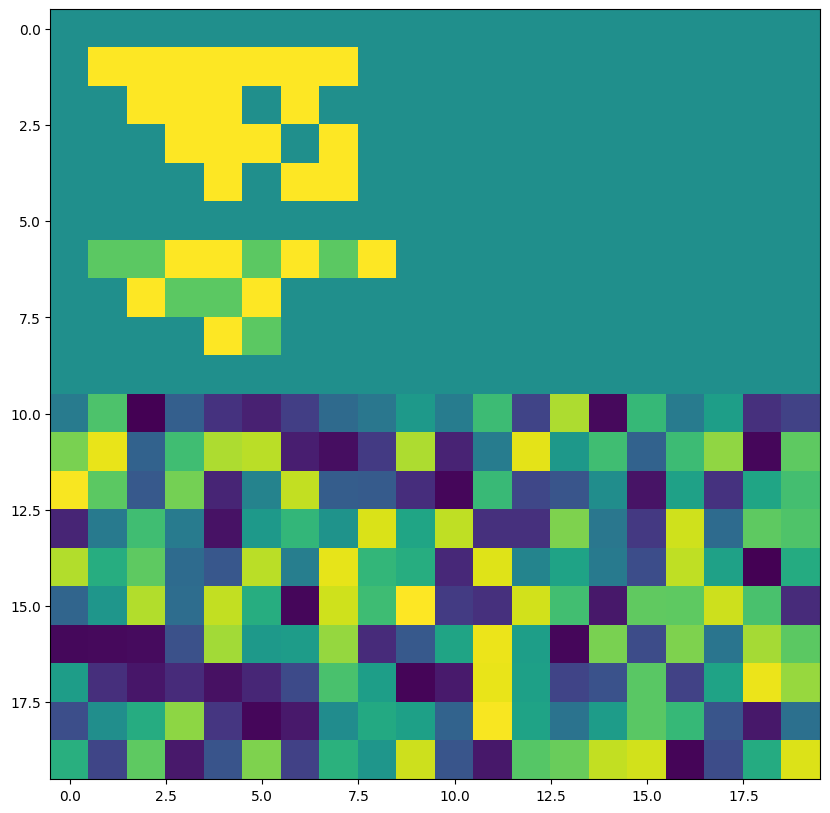

left_filled: 0
right_filled: 5
left_filled: 0
right_filled: 3


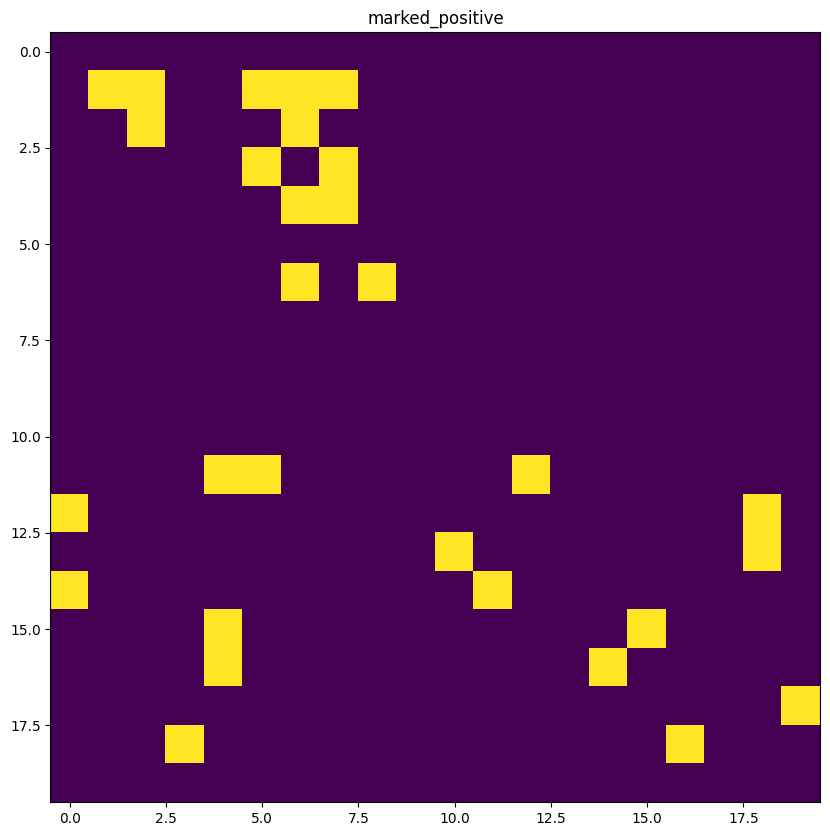

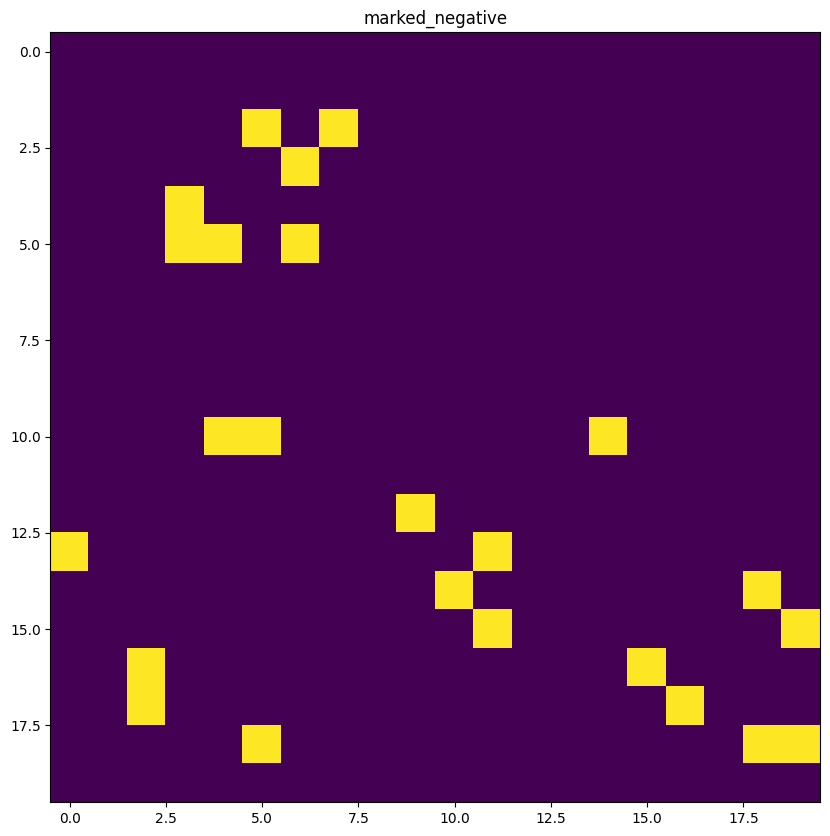

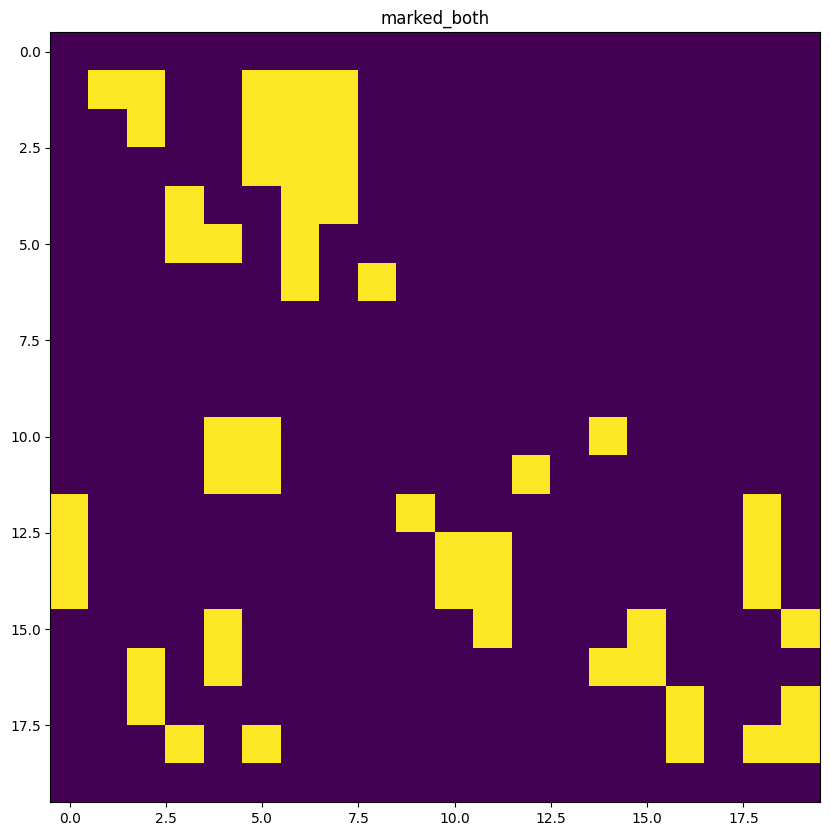

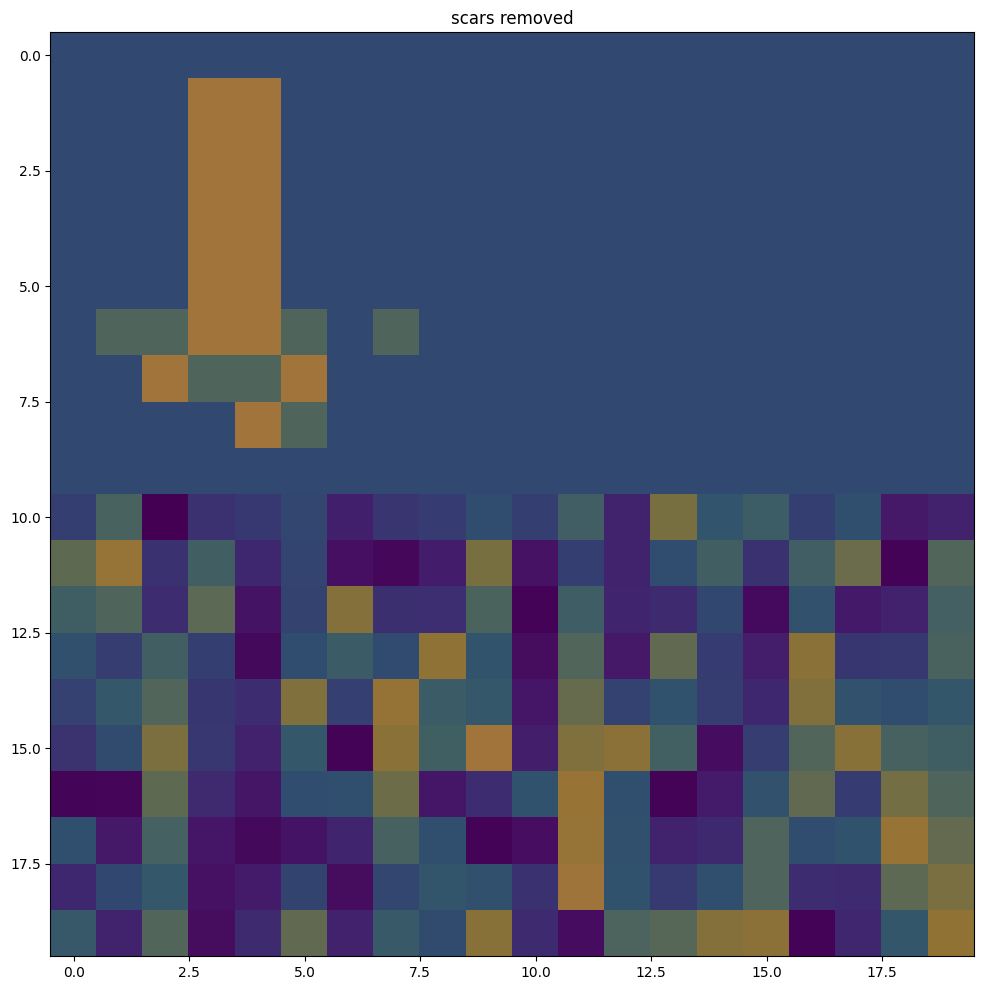

left_filled: 0
right_filled: 0
left_filled: 0
right_filled: 0


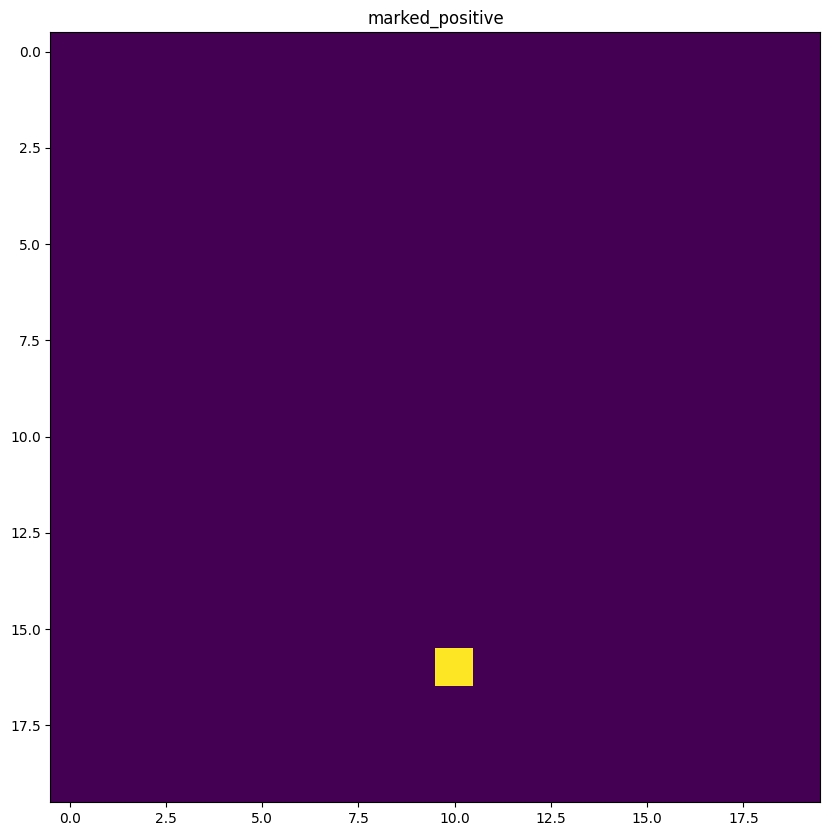

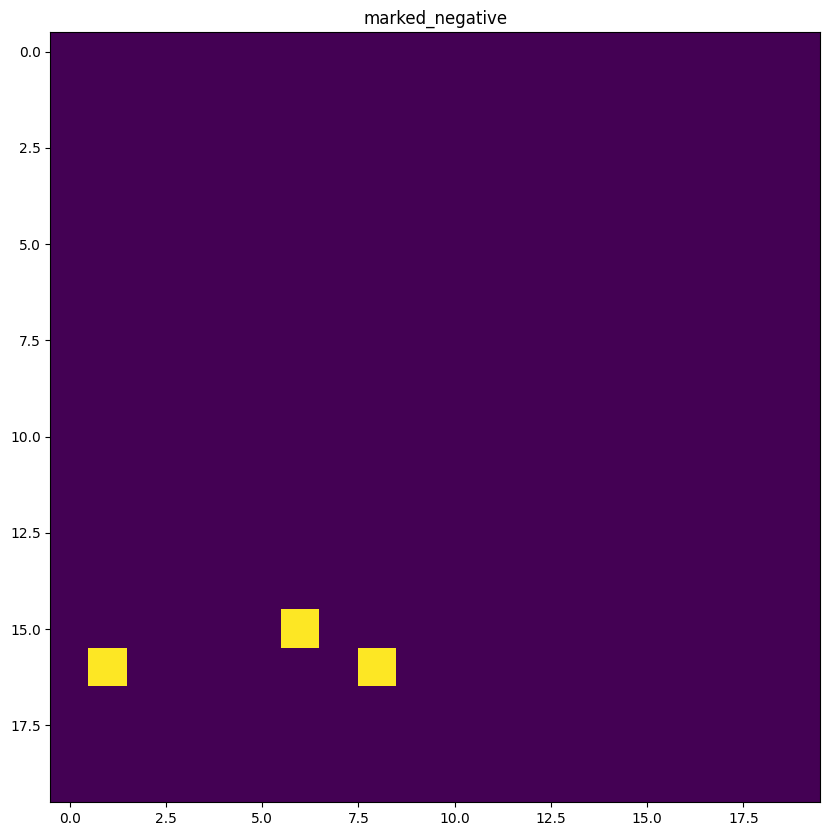

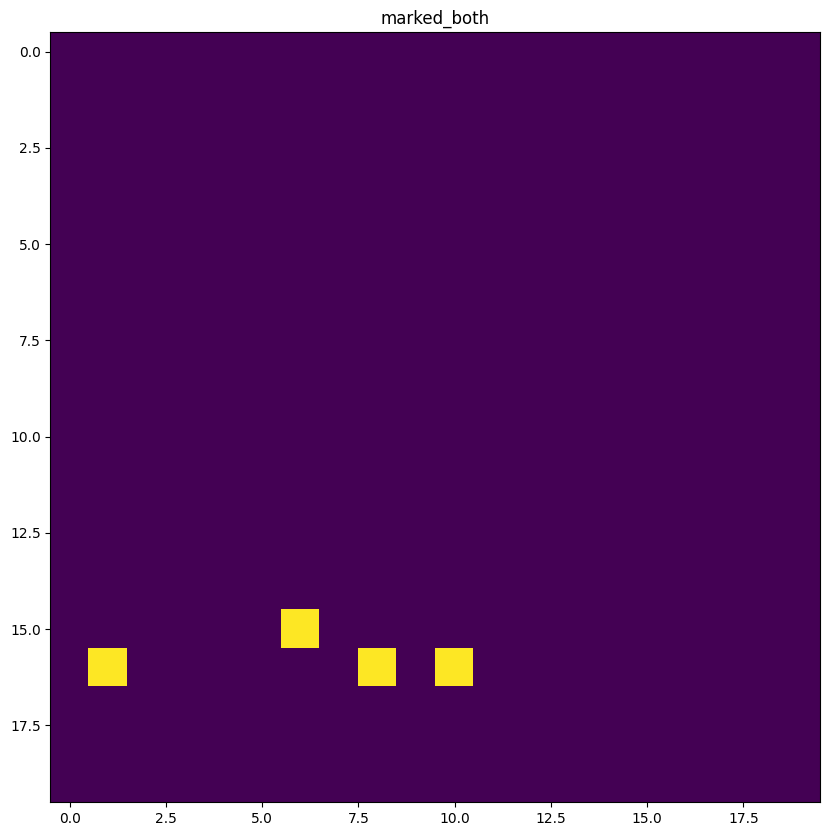

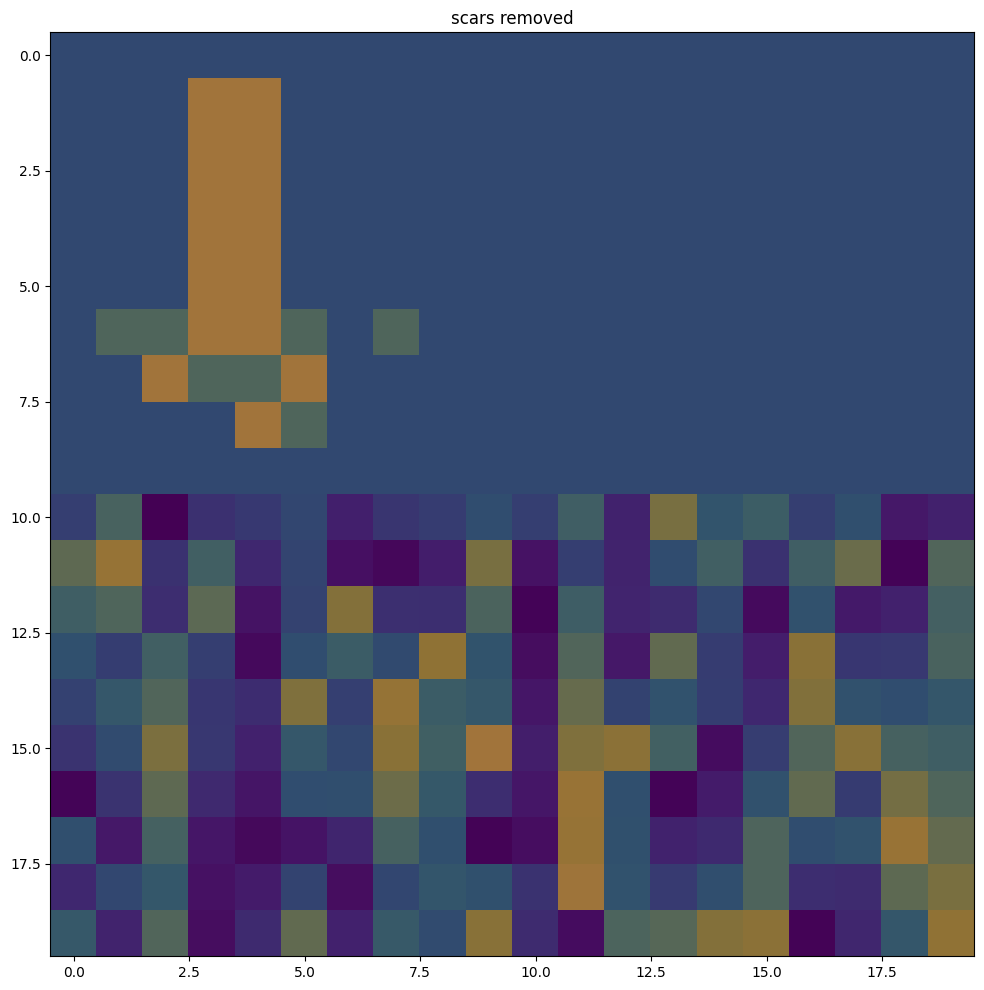

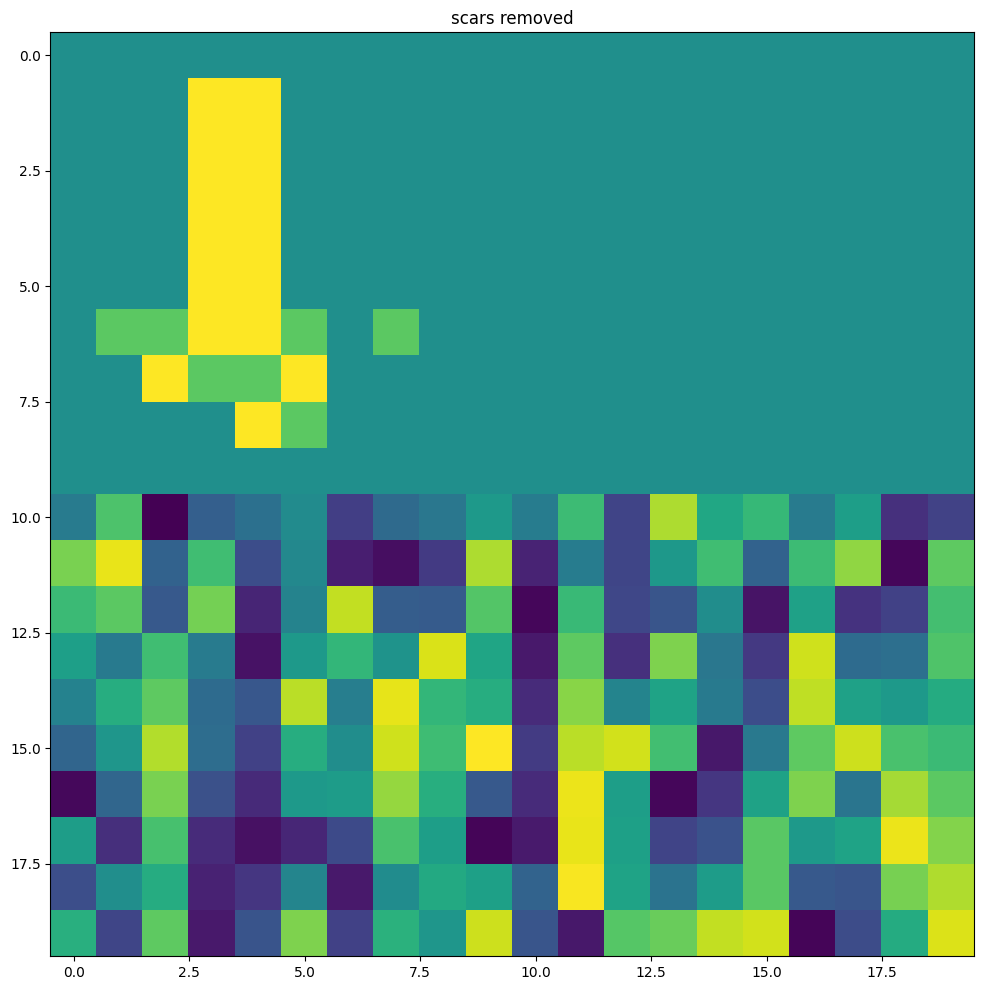

equal ✅


In [475]:
# validation for 20220208_7ng_piano_3mMNiCl2.0_00004 (1).spm: 
    # threshold_low = 1.5, threshold_high = 1.8, max_scar_width = 2, min_scar_length = 4
# validation for testimg:
    # threshold_low = 1.5, threshold_high = 1.8, max_scar_width = 2, min_scar_length = 1

LOGGING = False
def log(text):
    if LOGGING:
        print(text)

# img = np.copy(testimg2)
img = np.copy(testimg)
# img = np.copy(initial_flattened)

image = np.copy(img)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image, interpolation="None")
# for row in range(image.shape[0]):
#     for col in range(image.shape[1]):
#         plt.text(col, row, image[row, col])
plt.show()

# Remove simultaneously
for i in range(2):
    marked_positive = mark_scars(image, 'positive', threshold_low = 1.5, threshold_high = 1.8, max_scar_width = 2, min_scar_length = 1)
    marked_negative = mark_scars(image, 'negative', threshold_low = 1.5, threshold_high = 1.8, max_scar_width = 2, min_scar_length = 1)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(marked_positive, interpolation=None)
    ax.set_title('marked_positive')
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(marked_negative, interpolation=None)
    ax.set_title('marked_negative')
    plt.show()

    marked_both = np.bitwise_or(marked_positive.astype(bool), marked_negative.astype(bool))

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(marked_both, interpolation=None)
    ax.set_title('marked_both')
    plt.show()

    image = remove_marked_scars(image, marked_both)

    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(image, interpolation="None")
    ax.imshow(marked_both, alpha=0.5)
    ax.set_title('scars removed')
    plt.show()

# LOGGING = False

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(image, interpolation="None")
# for row in range(image.shape[0]):
#     for col in range(image.shape[1]):
#         plt.text(col, row, image[row, col])
ax.set_title('scars removed')
plt.show()

if (np.array_equal(image, np.load('./remove_scars_validation_testimg.npy'))):
    print('equal ✅')
else:
    print('not equal ❌')
    raise ValueError

